# Lesson 1 - What's your pet

Welcome to lesson 1!

In this lesson we will build our first image classifier from scratch, and see if we can achieve world-class results. Let's dive in!

Every notebook starts with the following three lines; they ensure that any edits to libraries you make are reloaded here automatically, and also that any charts or images displayed are shown in this notebook. These things starting % are special directives to Jupyter Notebook itself, they are not Python code. They are called "magics."

* If somebody changes underlying library code while I'm running this, please reload it automatically* 
* If somebody asks to plot something, then please plot it here in this Jupyter Notebook

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

We import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate

If you're using a computer with an unusually small GPU, you may get an out of memory error when running this notebook. If this happens, click Kernel->Restart, uncomment the 2nd line below to use a smaller *batch size* (you'll learn all about what this means during the course), and try again.

In [3]:
bs = 64
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

## Looking at the data

We are going to use the [Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/) by [O. M. Parkhi et al., 2012](http://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf) which features 12 cat breeds and 25 dogs breeds. Our model will need to learn to differentiate between these 37 distinct categories. According to their paper, the best accuracy they could get in 2012 was 59.21%, using a complex model that was specific to pet detection, with separate "Image", "Head", and "Body" models for the pet photos. Let's see how accurate we can be using deep learning!

We are going to use the `untar_data` function to which we must pass a URL as an argument and which will download and extract the data. 

In [4]:
help(untar_data)

Help on function untar_data in module fastai.datasets:

untar_data(url:str, fname:Union[pathlib.Path, str]=None, dest:Union[pathlib.Path, str]=None, data=True, force_download=False) -> pathlib.Path
    Download `url` to `fname` if it doesn't exist, and un-tgz to folder `dest`.



In this case, url is a string, fname is either path or a string and defaults to nothing (Union means "either"). dest is either a string or a path and defaults to nothing.

In [5]:
path = untar_data(URLs.PETS); path

PosixPath('/home/ec2-user/.fastai/data/oxford-iiit-pet')

In [6]:
path.ls()

[PosixPath('/home/ec2-user/.fastai/data/oxford-iiit-pet/annotations'),
 PosixPath('/home/ec2-user/.fastai/data/oxford-iiit-pet/images')]

In [7]:
path_anno = path/'annotations'
path_img = path/'images'

The first thing we do when we approach a problem is to take a look at the data. We _always_ need to understand very well what the problem is and what the data looks like before we can figure out how to solve it. Taking a look at the data means understanding how the data directories are structured, what the labels are and what some sample images look like.

The main difference between the handling of image classification datasets is the way labels are stored. In this particular dataset, labels are stored in the filenames themselves. We will need to extract them to be able to classify the images into the correct categories. Fortunately, the fastai library has a handy function made exactly for this, `ImageDataBunch.from_name_re` gets the labels from the filenames using a [regular expression](https://docs.python.org/3.6/library/re.html).

In [8]:
help(get_image_files)

Help on function get_image_files in module fastai.vision.data:

get_image_files(c:Union[pathlib.Path, str], check_ext:bool=True, recurse=False) -> Collection[pathlib.Path]
    Return list of files in `c` that are images. `check_ext` will filter to `image_extensions`.



In [9]:
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('/home/ec2-user/.fastai/data/oxford-iiit-pet/images/keeshond_166.jpg'),
 PosixPath('/home/ec2-user/.fastai/data/oxford-iiit-pet/images/Ragdoll_121.jpg'),
 PosixPath('/home/ec2-user/.fastai/data/oxford-iiit-pet/images/beagle_89.jpg'),
 PosixPath('/home/ec2-user/.fastai/data/oxford-iiit-pet/images/american_bulldog_171.jpg'),
 PosixPath('/home/ec2-user/.fastai/data/oxford-iiit-pet/images/pug_161.jpg')]

This is a pretty common way for computer vision datasets to get passed around - just one folder with a whole bunch of files in it. So the interesting bit then is how do we get the labels. In machine learning, the labels refer to the thing we are trying to predict. If we just eyeball this, we could immediately see that the labels are actually part of the file names. It's kind of like path/label_number.extension. We need to somehow get a list of label bits of each file name, and that will give us our labels. Because that's all you need to build a deep learning model:
* Pictures (files containing the images)
* Labels

In fastai we use an object called ImageDataBunch. An ImageDataBunch represents all of the data you need to build a model and there's some factory method which try to make it really easy for you to create that data bunch - a training set, a validation set with images and labels.

In [10]:
np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$'

**Transforms** - We should check and transform the images to same size. So basically what it'll do is something called by default center cropping which means it'll grab the middle bit and it'll also resize it. We'll talk more about the detail of this because it turns out to actually be quite important, but basically it uses a combination of resizing, zooming and cropping. 

**Image size** - Models are designed so that the final layer is of size 7 by 7, so we actually want something where if you go 7 times 2 a bunch of times (224 = 7*2^5), then you end up with something that's a good size.. 224 by 224, for reasons we'll learn about, is an extremely common size that most models tend to use so if you just use size=224, you're probably going to get pretty good results most of the time. 

In [11]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224, bs=bs)


`ImageDataBunch.from_name_re` is going to return a `DataBunch` object. In fastai, everything you model with is going to be a DataBunch object. Basically DataBunch object contains 2 or 3 datasets - it contains your training data, validation data, and optionally test data. For each of those, it contains your images and your labels, your texts and your labels, or your tabular data and your labels, or so forth. And that all sits there in this one place(i.e. data).

We then want to normalize the image data to make sure that each RGB channel of each image has a mean of 0 and standard deviation of 1. This is really important in deep learning applications. Without it, the range of pixel values will be between 0-255 and running pretrained networks with these values will give very bad results as these networks were trained on normalized images.
If ur training ur own network without transfer learning(i.e.randomly initialized weights), then this is not a mandatory thing to do as batch norm layers will take care of it in later stages but still a good thing to have to help smoother optimization

imagenet_stats - imagenet_stats are the channel mean and standard deviation values specific to the Imagenet dataset (one which we are using to train model for transfer learning).

In [12]:
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (5912 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
keeshond,Ragdoll,beagle,Abyssinian,Egyptian_Mau
Path: /home/ec2-user/.fastai/data/oxford-iiit-pet/images;

Valid: LabelList (1478 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Birman,Russian_Blue,yorkshire_terrier,great_pyrenees,yorkshire_terrier
Path: /home/ec2-user/.fastai/data/oxford-iiit-pet/images;

Test: None

_It is important to look at the data_ 

One of the most important thing to be a really good practitioner is to be able to look at your data. So it's really important to remember to go to data.show_batch and take a look. It's surprising how often when you actually look at the dataset you've been given that you realize it's got weird black borders on it, some of the things have text covering up some of it, or some of it is rotated in odd ways. So make sure you take a look.

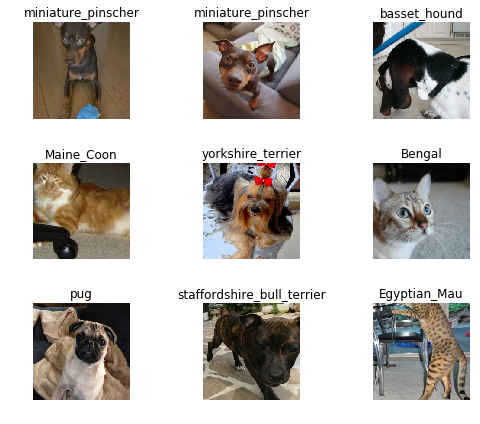

In [13]:
data.show_batch(rows=3, figsize=(7,6))

data.classes - #labels  

data.c  - #classes for classification problems, for regression its diff 

In [14]:
print(data.classes)
len(data.classes),data.c

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


(37, 37)

## Training: resnet34

Now we will start training our model. We will use a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier. Don't know what these things mean? Not to worry, we will dive deeper in the coming lessons. For the moment you need to know that we are building a model which will take images as input and will output the predicted probability for each of the categories (in this case, it will have 37 outputs).

We will train for 4 epochs (4 cycles through all our data).

In [15]:
from fastai import __version__
print(__version__)

1.0.48


Note: "create_cnn" won’t exist anymore in v1.0.47 and later on, it will be replaced by cnn_learner for consistency with all the other convenience functions that return a Learner.

In [16]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

**Transfer learning**

The first time I run this on a newly installed box, it downloads the ResNet34 pre-trained weights. What that means is that this particular model has actually already been trained for looking at about one and a half million pictures of all kinds of different things, a thousand categories of things, using an image dataset called ImageNet. So we can download those pre-trained weights so that we don't start with a model that knows nothing about anything, but we actually start with a model that knows how to recognize a thousand categories of things in ImageNet. I don't think all of these 37 categories of pet are in ImageNet but there were certainly some kinds of dog and some kinds of cat. So this pre-trained model knows quite a little bit about what pets look like, and it certainly knows quite a lot about what animals look like and what photos look like. So the idea is that we don't start with a model that knows nothing at all, but we start by downloading a model that knows something about recognizing images already. So it downloads for us automatically, the first time we use it, a pre-trained model and then from now on, it won't need to download it again - it'll just use the one we've got. 

We are going to learn a lot about this. It's kind of the focus of the whole course which is how to do this thing called "transfer learning." How to take a model that already knows how to do something pretty well and make it so that it can do your thing really well. We will take a pre-trained model, and then we fit it so that instead of predicting a thousand categories of ImageNet with ImageNet data, it predicts the 37 categories of pets using your pet data. By doing this, you can train models in 1/100 or less of the time of regular model training with 1/100 or less of the data of regular model training. Potentially, many thousands of times less. 



In [17]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [18]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.401354,0.329454,0.100135,00:59
1,0.563595,0.253396,0.082544,00:58
2,0.340025,0.219686,0.070365,00:57
3,0.250153,0.205068,0.066982,00:59


This number, 4, basically decides how many times do we go through the entire dataset, how many times do we show the dataset to the model so that it can learn from it. Each time it sees a picture, it's going to get a little bit better. But it's going to take time and it means it could overfit. 

In [19]:
learn.save('stage-1')

## Results

Let's see what results we have got. 

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

To see what comes out, we could use `ClassificationInterpretation` class for class interpretation. We are going to use this factory method from learner, so we pass in a learn object. Remember a learn object knows two things:

1. What's your data
2. What is your model. 

Now it's not just an architecture, it's actually a trained model. That's all the information we need to interpret that model.

In [20]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

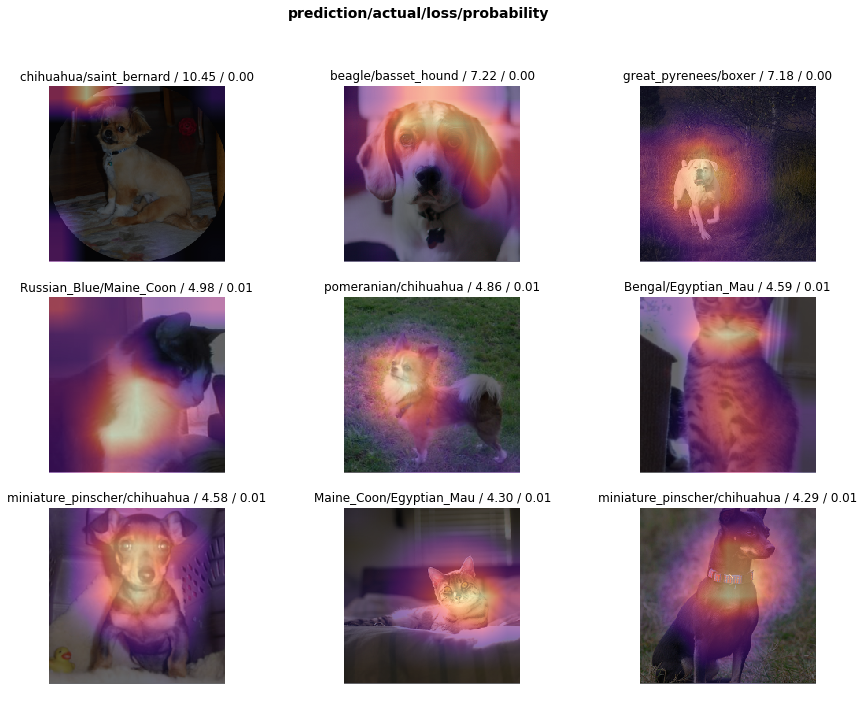

In [21]:
interp.plot_top_losses(9, figsize=(15,11))

In [22]:
doc(interp.plot_top_losses)

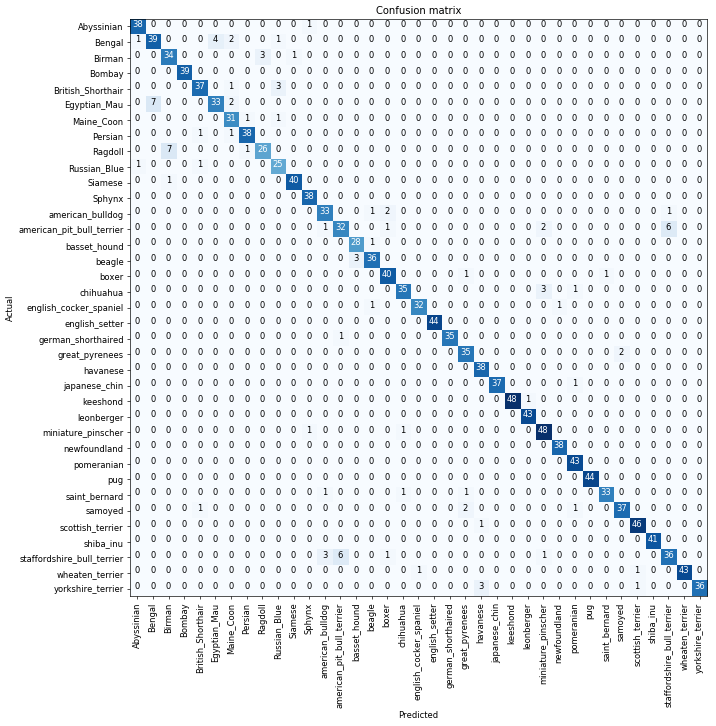

In [23]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

`most_confused` will simply grab out of the confusion matrix the particular combinations of predicted and actual that got wrong the most often. So this case, ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 7):

Actual 'american_pit_bull_terrier'
Prediction 'staffordshire_bull_terrier'
This particular combination happened 5 times.

In [24]:
interp.most_confused(min_val=2)

[('Egyptian_Mau', 'Bengal', 7),
 ('Ragdoll', 'Birman', 7),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 6),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 6),
 ('Bengal', 'Egyptian_Mau', 4),
 ('Birman', 'Ragdoll', 3),
 ('British_Shorthair', 'Russian_Blue', 3),
 ('beagle', 'basset_hound', 3),
 ('chihuahua', 'miniature_pinscher', 3),
 ('staffordshire_bull_terrier', 'american_bulldog', 3),
 ('yorkshire_terrier', 'havanese', 3),
 ('Bengal', 'Maine_Coon', 2),
 ('Egyptian_Mau', 'Maine_Coon', 2),
 ('american_bulldog', 'boxer', 2),
 ('american_pit_bull_terrier', 'miniature_pinscher', 2),
 ('great_pyrenees', 'samoyed', 2),
 ('samoyed', 'great_pyrenees', 2)]

## Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

Let's make our model better. How? We can make it better by using fine-tuning. So far we fitted 4 epochs and it ran pretty quickly. The reason it ran pretty quickly is that there was a little trick we used. These convolutional networks, they have many layers. We'll learn a lot about exactly what layers are, but for now, just know it goes through a lot of computations. What we did was we added a few extra layers to the end and we only trained those. We basically left most of the model exactly as it was, so that's really fast. If we are trying to build a model at something that's similar to the original pre-trained model (in this case, similar to the ImageNet data), that works pretty well.

But what we really want to do is to go back and train the whole model. This is why we pretty much always use this two stage process. By default, when we call `fit` or `fit_one_cycle` on a ConvLearner, it'll just fine-tune these few extra layers added to the end and it will run very fast. It will basically never overfit but to really get it good, you have to call unfreeze. `unfreeze` is the thing that says please train the whole model. Then I can call `fit_one_cycle` again.

In [25]:
learn.unfreeze()

In [26]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.525894,0.313681,0.086604,01:07


Uh-oh. The error got much worse. Why? Explained in the research paper. See video or https://github.com/hiromis/notes/blob/master/Lesson1.md for more info. 

Basically for the pre-trained model on ImageNet pictures the start or first-layer of my neural net is going to find very simple gradients and lines, the second layer can find very simple shapes, the third layer can find combination of those.

Layer 4 can take all the stuff from layer 3 and combine them together. By layer 4, we got something that can find dog faces or bird legs.

By layer 5, we've got something that can find the eyeballs of bird and lizards, or faces of particular breeds of dogs and so forth. So you can see how by the time you get to layer 34, you can find specific dog breeds and cat breeds. This is kind of how it works.

So when we first trained (i.e. fine-tuned) the pre-trained model, we kept all of these layers that you've seen so far and we just trained a few more layers on top of all of those sophisticated features that are already being created. So now we are going back and saying "let's change all of these". We will start with where they are, but let's see if we can make them better.

Now, it seems very unlikely that we can make layer 1 features better. It's very unlikely that the definition of a diagonal line is going to be different when we look at dog and cat breeds versus the ImageNet data that this was originally trained on. So we don't really want to change the layer 1 very much if at all. Or else, the last layers, like types of dog face seems very likely that we do want to change that. So you want this intuition, this understanding that the different layers of a neural network represents different level of semantic complexity.

This is why our attempt to fine-tune this model didn't work because by default, it trains all the layers at the same speed which is to say it will update those things representing diagonal lines and gradients just as much as it tries to update the things that represent the exact specifics of what an eyeball looks like, so we have to change that.

To change it, we first of all need to go back to where we were before. We just broke this model, much worse than it started out. So if we just go:

`learn.load('stage-1')`
This brings back the model that we saved earlier. So let's load that back up and now our models back to where it was before we killed it.

In [27]:
learn.load('stage-1');

### Learning Rate

Now we look at the **learning rate**. This is the thing that figures out what is the fastest I can train this neural network at without making it zip off the rails and get blown apart.

In [28]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


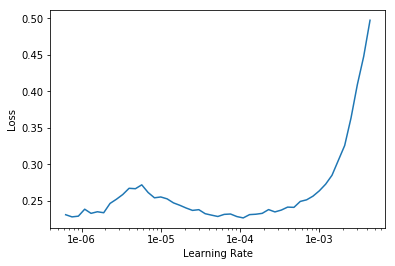

In [29]:
learn.recorder.plot()

This will plot the result of our LR finder and what this basically shows you is this key parameter called a learning rate. The learning rate basically says how quickly am I updating the parameters in my model. The x-axis one here shows me what happens as I increase the learning rate. The y axis show what the loss is. So you can see, once the learning rate gets passed 10^-4, my loss gets worse. It actually so happens, in fact I can check this if I press `shift+tab` here, my learning defaults to 0.003. So you can see why our loss got worse. Because we are trying to fine-tune things now, we can't use such a high learning rate. So based on the learning rate finder, I tried to pick something well before it started getting worse. So I decided to pick `1e-6`. But there's no point training all the layers at that rate, because we know that the later layers worked just fine before when we were training much more quickly. So what we can actually do is we can pass a range of learning rates to `learn.fit_one_cycle`. And we do it like this:

You use this keyword in Python called `slice` and that can take a start value and a stop value and basically what this says is train the very first layers at a learning rate of 1e-6, and the very last layers at a rate of 1e-4, and distribute all the other layers across that (i.e. between those two values equally).

In [30]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.217384,0.199398,0.066306,01:07
1,0.210800,0.193667,0.063599,01:06


That's a pretty accurate model!

#### How to pick learning rates after unfreezing [1:25:23]
A good rule of thumb is after you unfreeze (i.e. train the whole thing), pass a max learning rate parameter, pass it a slice, make the second part of that slice about 10 times smaller than your first stage. Our first stage defaulted to about 1e-3 so it's about 1e-4. And the first part of the slice should be a value from your learning rate finder which is well before things started getting worse. So you can see things are starting to get worse maybe about here:



So I picked something that's at least 10 times smaller than that.

If I do that, then the error rate gets a bit better. So I would perhaps say for most people most of the time, these two stages are enough to get pretty much a world-class model. You won't win a Kaggle competition, particularly because now a lot of fastai alumni are competing on Kaggle and this is the first thing that they do. But in practice, you'll get something that's about as good in practice as the vast majority of practitioners can do.

## Training: resnet50

Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers. It will be explained later in the course and you can learn the details in the [resnet paper](https://arxiv.org/pdf/1512.03385.pdf)).

Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here. To help it along, let's us use larger images too, since that way the network can see more detail. We reduce the batch size a bit since otherwise this larger network will require more GPU memory.

In [31]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(),
                                   size=299, bs=bs//2).normalize(imagenet_stats)

In [32]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


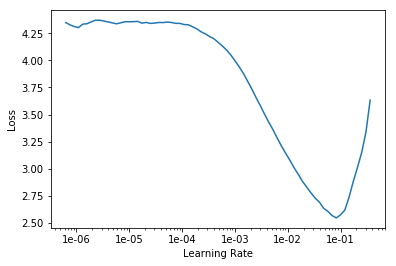

In [33]:
learn.lr_find()
learn.recorder.plot()

In [34]:
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate,time
0,0.722543,0.305013,0.087280,03:19
1,0.414683,0.235676,0.075778,03:13
2,0.327086,0.273149,0.081867,03:13
3,0.281669,0.219197,0.069012,03:14
4,0.202891,0.211005,0.062246,03:14
5,0.151178,0.197044,0.058187,03:14
6,0.113189,0.175254,0.056157,03:14
7,0.093071,0.172197,0.052774,03:14


In [35]:
learn.save('stage-1-50')

It's astonishing that it's possible to recognize pet breeds so accurately! Let's see if full fine-tuning helps:

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time


If it doesn't, you can always go back to your previous model.

In [ ]:
learn.load('stage-1-50');

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.most_confused(min_val=2)